In [32]:
import pandas as pd
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [33]:
import findspark

In [34]:
findspark.init()

In [35]:
from pyspark.sql import SparkSession

In [36]:
# Configure Spark session with increased timeout and Arrow enabled
spark = SparkSession.builder \
    .appName("ROC Curve") \
    .config("spark.network.timeout", "600s") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

In [37]:
from pyspark.ml.classification import RandomForestClassifier

In [38]:
# Use Spark to read in the Ecommerce Customers csv file.
df = spark.read.csv('healthcare-dataset-stroke-data.csv', header=True, inferSchema=True)

In [39]:
# Print the Schema of the DataFrame
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [40]:
df.show(10)

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

In [41]:
from pyspark.sql.functions import col, when
#Data Preprocessing
# Handle missing values (N/A in BMI) and cast columns to appropriate types
df = df.withColumn("age", col("age").cast("float"))\
       .withColumn("hypertension", col("hypertension").cast("integer"))\
       .withColumn("heart_disease", col("heart_disease").cast("integer"))\
       .withColumn("avg_glucose_level", col("avg_glucose_level").cast("float"))\
       .withColumn("bmi", when(col("bmi") == "N/A", None).otherwise(col("bmi").cast("float")))\
       .withColumn("stroke", col("stroke").cast("integer"))

In [42]:
# Preprocess bmi (handle N/A)
df = df.withColumn("bmi", when(col("bmi") == "N/A", None).otherwise(col("bmi").cast("float")))
mean_bmi = df.filter(col("bmi").isNotNull()).selectExpr("mean(bmi)").collect()[0][0]
df = df.na.fill({"bmi": mean_bmi})

# Ensure categorical columns are strings
categorical_cols = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]
for col_name in categorical_cols:
    df = df.withColumn(col_name, col(col_name).cast("string"))

In [43]:
# Print schema to verify types
print("DataFrame Schema:")
df.printSchema()

DataFrame Schema:
root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: float (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: float (nullable = true)
 |-- bmi: float (nullable = false)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [44]:
print("Sample Data:")
df.show(5)

Sample Data:
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+---------+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level|      bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+---------+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|     36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21|28.893236|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|     32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|     34.4|         smokes|     1|
| 1665|

In [45]:
# Convert to Pandas for visualization
df_pandas = df.toPandas()

# Verify Pandas DataFrame types
print("Pandas DataFrame Types:")
print(df_pandas.dtypes)

Pandas DataFrame Types:
id                     int32
gender                object
age                  float32
hypertension           int32
heart_disease          int32
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float32
bmi                  float32
smoking_status        object
stroke                 int32
dtype: object


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is 

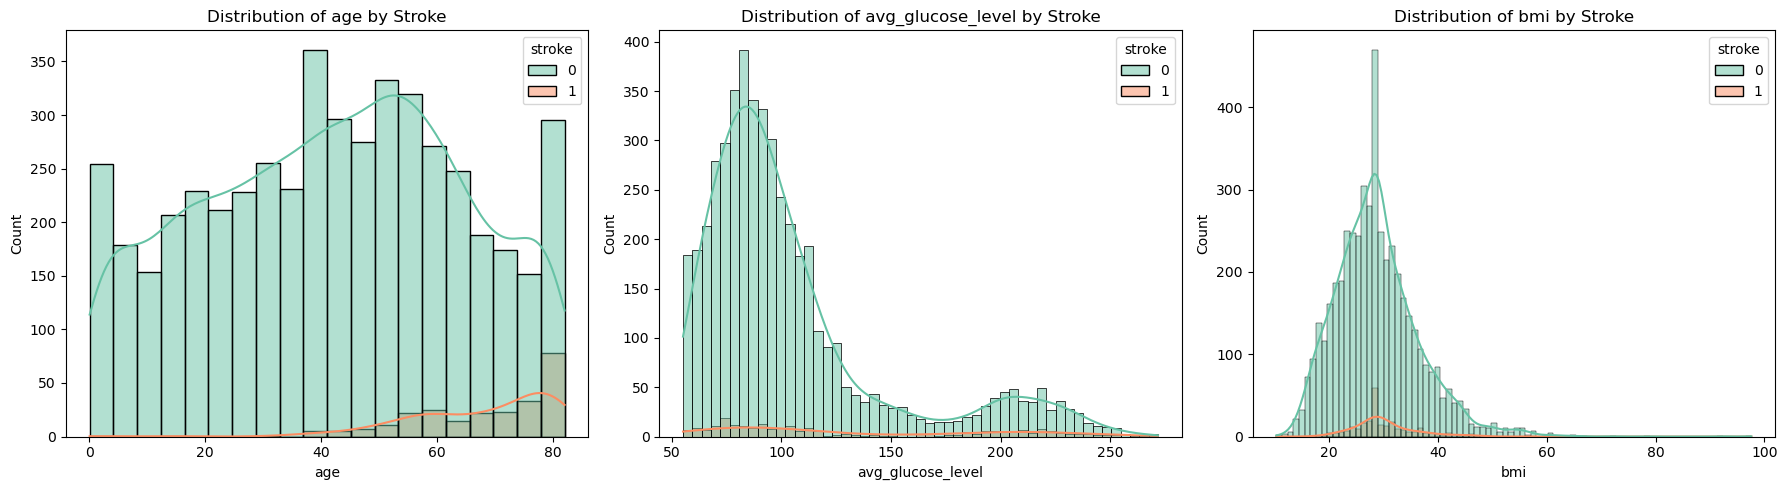

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import VectorAssembler


numeric_cols = ["age", "avg_glucose_level", "bmi"]

# Create horizontal subplots
fig, axes = plt.subplots(nrows=1, ncols=len(numeric_cols), figsize=(18, 5))

for idx, col_name in enumerate(numeric_cols):
    sns.histplot(
        data=df_pandas,
        x=col_name,
        hue="stroke",
        kde=True,
        palette="Set2",
        ax=axes[idx]
    )
    axes[idx].set_title(f'Distribution of {col_name} by Stroke')
    axes[idx].set_xlabel(col_name)
    axes[idx].set_ylabel('Count')

plt.tight_layout()
plt.show()

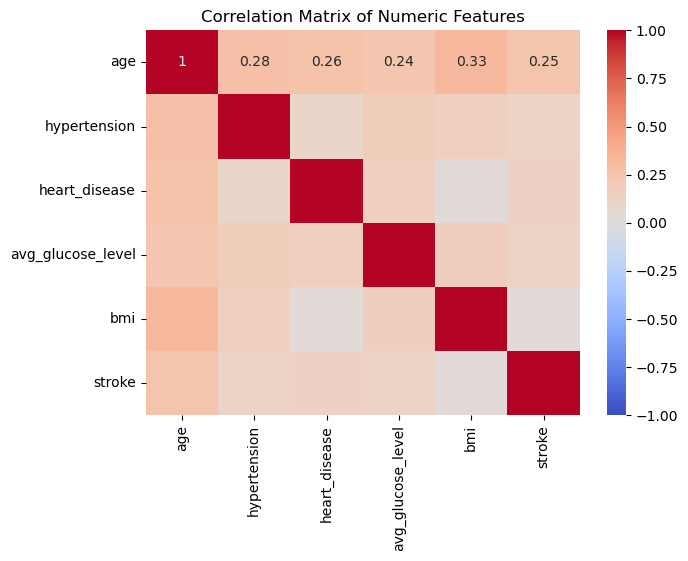

In [47]:
# Correlation Analysis
numeric_cols_corr = ["age", "hypertension", "heart_disease", "avg_glucose_level", "bmi", "stroke"]
assembler_corr = VectorAssembler(inputCols=numeric_cols_corr, outputCol="numeric_features", handleInvalid="skip")
df_numeric = assembler_corr.transform(df).select("numeric_features")
from pyspark.ml.stat import Correlation
corr_matrix = Correlation.corr(df_numeric, "numeric_features").head()[0].toArray()
corr_df = pd.DataFrame(corr_matrix, index=numeric_cols_corr, columns=numeric_cols_corr)
plt.figure(figsize=(7, 5))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

In [48]:
# --- Step 2: Check Class Imbalance ---

print("Class Distribution for 'stroke':")
df.groupBy("stroke").count().show()
total_count = df.count()
stroke_counts = df.groupBy("stroke").count().collect()
stroke_0 = next(row["count"] for row in stroke_counts if row["stroke"] == 0)
stroke_1 = next(row["count"] for row in stroke_counts if row["stroke"] == 1)
imbalance_ratio = stroke_0 / stroke_1
print(f"Imbalance Ratio (stroke=0 / stroke=1): {imbalance_ratio:.2f}")

Class Distribution for 'stroke':
+------+-----+
|stroke|count|
+------+-----+
|     1|  249|
|     0| 4861|
+------+-----+

Imbalance Ratio (stroke=0 / stroke=1): 19.52


In [49]:
# --- Step 3: Apply SMOTE ---

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

# Index categorical variables
categorical_columns = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index").setHandleInvalid("keep") 
            for col in categorical_columns]
indexing_pipeline = Pipeline(stages=indexers)
df_indexed = indexing_pipeline.fit(df).transform(df)

# Define feature columns based on available columns
feature_columns = ["age", "hypertension", "heart_disease", "avg_glucose_level", "bmi", 
                   "gender_index", "ever_married_index", "work_type_index", 
                   "Residence_type_index", "smoking_status_index"]

In [50]:
# Assemble features
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features", handleInvalid="skip")
df_assembled = assembler.transform(df_indexed).select("features", "stroke")

# Convert to Pandas for SMOTE
df_pandas = df_assembled.toPandas()
X = pd.DataFrame(df_pandas["features"].tolist(), columns=feature_columns)
y = df_pandas["stroke"]

In [51]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [52]:
# Combine resampled features and labels into a DataFrame
resampled_df = pd.concat([X_resampled, pd.Series(y_resampled, name="stroke")], axis=1)

# Convert back to Spark DataFrame
resampled_spark_df = spark.createDataFrame(resampled_df)

# Reassemble features in the resampled Spark DataFrame
assembler_resampled = VectorAssembler(inputCols=feature_columns, outputCol="features", handleInvalid="skip")
resampled_spark_df = assembler_resampled.transform(resampled_spark_df).select("features", "stroke")

Class Distribution after SMOTE:
+------+-----+
|stroke|count|
+------+-----+
|     1| 4861|
|     0| 4861|
+------+-----+



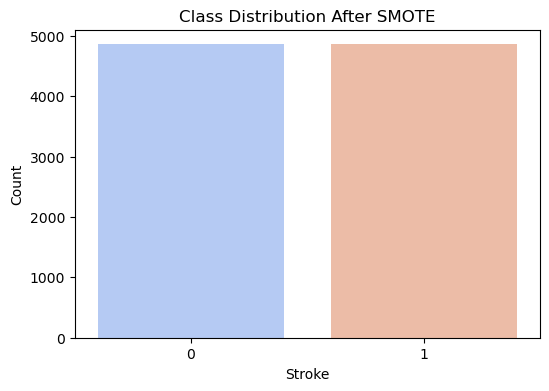

In [53]:
# Check new class distribution
print("Class Distribution after SMOTE:")
resampled_spark_df.groupBy("stroke").count().show()

# Visualize new distribution
resampled_pandas = resampled_spark_df.toPandas()
plt.figure(figsize=(6, 4))
sns.countplot(data=resampled_pandas, x="stroke", palette="coolwarm")
plt.title('Class Distribution After SMOTE')
plt.xlabel('Stroke')
plt.ylabel('Count')
plt.show()

In [54]:
# --- Optional: Train Random Forest with Resampled Data ---

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Split resampled data
train_df, test_df = resampled_spark_df.randomSplit([0.8, 0.2], seed=42)

In [55]:
# Define Random Forest Classifier
rf = RandomForestClassifier(labelCol="stroke", featuresCol="features", numTrees=100, maxDepth=10, seed=42)

In [56]:
#Create and fit pipeline
pipeline = Pipeline(stages=[rf])
model = pipeline.fit(train_df)

In [57]:
# Make predictions and evaluate
predictions = model.transform(test_df)
evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy after SMOTE: {accuracy:.4f}")

Accuracy after SMOTE: 0.9673


In [58]:
# Calculate additional metrics
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.9675
Recall: 0.9673
F1 Score: 0.9672


Area Under ROC: 0.9945


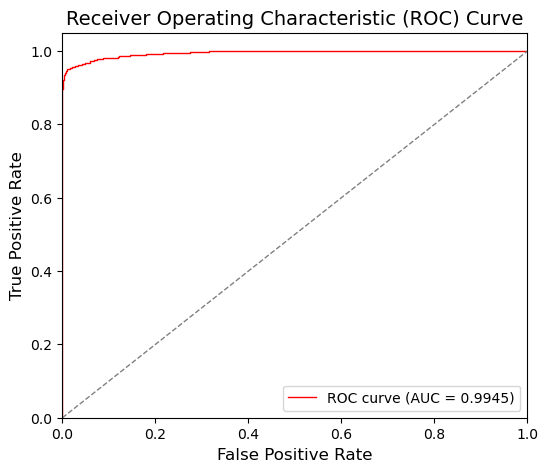

In [59]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# --- ROC Curve ---
binary_evaluator = BinaryClassificationEvaluator(labelCol="stroke", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = binary_evaluator.evaluate(predictions)
print(f"Area Under ROC: {roc_auc:.4f}")

# Extract ROC curve data (requires conversion to Pandas for plotting)
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
extract_prob = udf(lambda x: float(x[1]), FloatType())
predictions_with_prob = predictions.select("stroke", extract_prob("probability").alias("probability"))
roc_df = predictions_with_prob.toPandas()

from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(roc_df["stroke"], roc_df["probability"])
roc_auc_sklearn = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='red', lw=1, label=f'ROC curve (AUC = {roc_auc_sklearn:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc="lower right")
plt.show()

C:\Users\kapil\AppData\Roaming\Python\Python311\site-packages\pyspark\sql\context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



Confusion Matrix:
[[958.  20.]
 [ 43. 903.]]


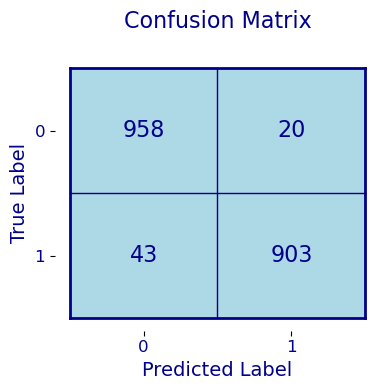

In [60]:
from pyspark.mllib.evaluation import MulticlassMetrics
from matplotlib.patches import Rectangle

# --- Confusion Matrix ---
prediction_and_labels = predictions.select("prediction", "stroke").rdd.map(lambda row: (float(row[0]), float(row[1])))
metrics = MulticlassMetrics(prediction_and_labels)
confusion_matrix = metrics.confusionMatrix().toArray()
print("\nConfusion Matrix:")
print(confusion_matrix)

# Plot confusion matrix
plt.figure(figsize=(4, 4))
plt.gca().add_patch(Rectangle((0, 1), 1, 1, facecolor='lightblue', edgecolor='none'))
plt.gca().add_patch(Rectangle((1, 1), 1, 1, facecolor='lightblue', edgecolor='none'))
plt.gca().add_patch(Rectangle((0, 0), 1, 1, facecolor='lightblue', edgecolor='none'))
plt.gca().add_patch(Rectangle((1, 0), 1, 1, facecolor='lightblue', edgecolor='none'))
plt.plot([0, 2], [0, 0], 'darkblue', lw=2)
plt.plot([0, 2], [2, 2], 'darkblue', lw=2)
plt.plot([0, 0], [0, 2], 'darkblue', lw=2)
plt.plot([2, 2], [0, 2], 'darkblue', lw=2)
plt.plot([1, 1], [0, 2], 'darkblue', lw=1)
plt.plot([0, 2], [1, 1], 'darkblue', lw=1)
plt.text(0.5, 1.5, f'{int(confusion_matrix[0][0])}', ha='center', va='center', fontsize=16, color='darkblue')
plt.text(1.5, 1.5, f'{int(confusion_matrix[0][1])}', ha='center', va='center', fontsize=16, color='darkblue')
plt.text(0.5, 0.5, f'{int(confusion_matrix[1][0])}', ha='center', va='center', fontsize=16, color='darkblue')
plt.text(1.5, 0.5, f'{int(confusion_matrix[1][1])}', ha='center', va='center', fontsize=16, color='darkblue')
plt.title('Confusion Matrix', fontsize=16, pad=20, color='darkblue')
plt.xlabel('Predicted Label', fontsize=14, color='darkblue')
plt.ylabel('True Label', fontsize=14, color='darkblue')
plt.xticks([0.5, 1.5], [0, 1], fontsize=12, color='darkblue')
plt.yticks([0.5, 1.5], [1, 0], fontsize=12, color='darkblue')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.tight_layout()
plt.show()


Feature Importance:
                feature  importance
0                   age    0.296675
1          hypertension    0.129465
6    ever_married_index    0.121601
8  Residence_type_index    0.108897
5          gender_index    0.078975
9  smoking_status_index    0.066932
2         heart_disease    0.066754
3     avg_glucose_level    0.050367
7       work_type_index    0.049044
4                   bmi    0.031289


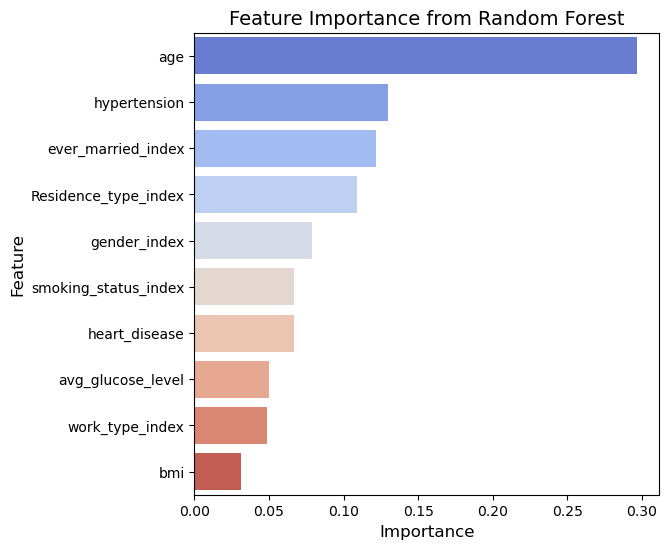

In [61]:
# --- Feature Importance ---
rf_model = model.stages[-1]  # Extract Random Forest model from pipeline
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.featureImportances.toArray()
}).sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(6, 6))
sns.barplot(data=feature_importance, x='importance', y='feature', palette='coolwarm')
plt.title('Feature Importance from Random Forest', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

In [62]:
# Clean up
spark.stop()